In [1]:
from tensorflow.keras.applications import VGG16

#
conv_base = VGG16(weights='imagenet',
 include_top=False,
 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import numpy as np

train_dir = 'D:\\TrainData\\dog_cat_small\\train'
validation_dir = 'D:\\TrainData\\dog_cat_small\\validation'
test_dir = 'D:\\TrainData\\dog_cat_small\\test'

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        # 使用预训练的卷积基提取特征
        # (None, 4, 4, 512)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features,labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000) 
test_features, test_labels = extract_features(test_dir, 1000)
#提取的特征形状为 (samples, 4, 4, 512)。我们要将其输入到密集连接分类器中，
#所以首先必须将其形状展平为 (samples, 8192)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
 loss='binary_crossentropy',
 metrics=['acc'])
history = model.fit(train_features, train_labels,
 epochs=30,
 batch_size=20,
 validation_data=(validation_features, validation_labels))

model.save('cats_and_dogs_small_3.h5')


Found 2000 images belonging to 2 classes.
1/1 [==============================] - 1s 500ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 506ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 1s 500ms/step


Epoch 1/30
100/100 [==============================] - 2s 16ms/step - loss: 0.7897 - acc: 0.7365 - val_loss: 0.5031 - val_acc: 0.7480
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.3506 - acc: 0.8465 - val_loss: 0.2704 - val_acc: 0.8960
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2735 - acc: 0.8935 - val_loss: 0.3524 - val_acc: 0.8430
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2567 - acc: 0.8915 - val_loss: 0.2459 - val_acc: 0.9010
Epoch 5/30
100/100 [==============================] - 1s 14ms/step - loss: 0.2183 - acc: 0.9080 - val_loss: 0.2462 - val_acc: 0.9100
Epoch 6/30
100/100 [==============================] - 1s 14ms/step - loss: 0.1783 - acc: 0.9300 - val_loss: 0.2658 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 1s 14ms/step - loss: 0.1537 - acc: 0.9425 - val_loss: 0.4373 - val_acc: 0.8670
Epoch 8/30
100/100 [==============================] - 1s 14ms/step - 

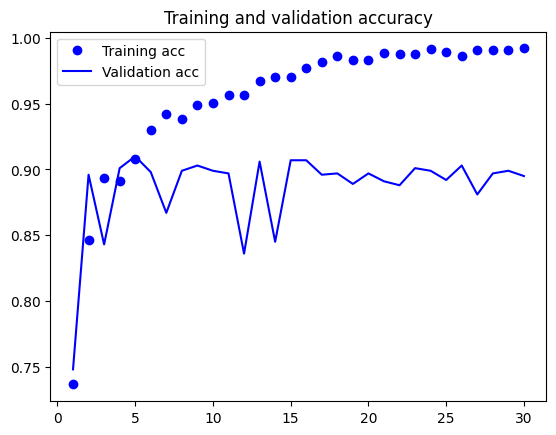

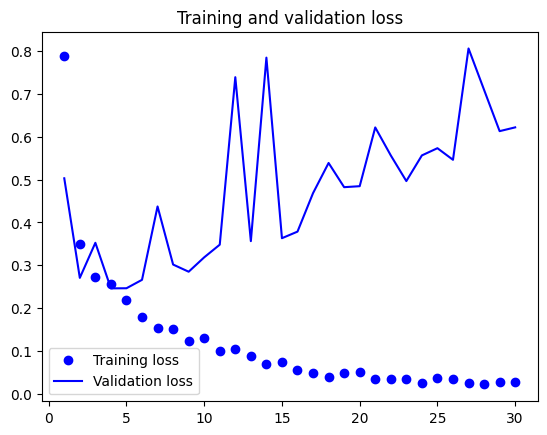

In [4]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()